## Instalación de librerías:

Instalamos las librerías necesarias para ejecutar nuestro código:

 ----- otras librerías de cerebros pero que no me fueron útiles ahora ------

pip install nipype

pip install nltools

pip install bids

pip install ciftify


In [ ]:
pip install nilearn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 25.2 MB/s eta 0:00:00


In [ ]:
pip install cpac

## Importación de datos:

Conectamos con google drive la data funcional (errts) y anatómica (classes) y la extraemos a este archivo.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# aquí podemos ver los archivos que hay en la carpeta, tal como ls funciona:

import os
os.chdir("/content/drive/MyDrive/100307")
!ls

alff_result.nii.gz		   errts.corte_prueba.tcat+tlrc.HEAD  nilearn_cache
Classes+tlrc.BRIK		   falff_result.nii.gz		      reho_map.nii.gz
Classes+tlrc.HEAD		   metricas.ipynb		      reho.nii.gz
errts.corte_prueba.tcat+tlrc.BRIK  neighbor_average_mask.nii.gz


In [ ]:
# extraemos la data que queremos con /content/drive/MyDrive:

fmri_file_path = r'/content/drive/MyDrive/100307/errts.corte_prueba.tcat+tlrc.BRIK'
anat = r'/content/drive/MyDrive/100307/Classes+tlrc.BRIK'
path = r'/content/drive/MyDrive/100307'
cortes = 200 # tamaño de los cortes del cerebro, por si sirve de algo


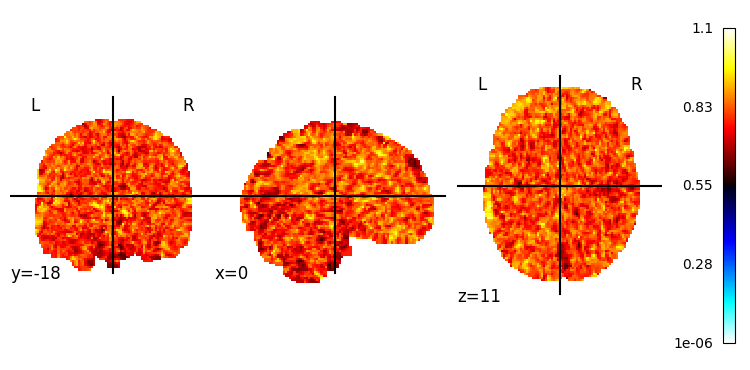

In [ ]:
# para graficar la data en 3D, solo acepta .nii, no .BRIK:

from nilearn import plotting
from nilearn.image import load_img

imagen_de_prueba = r'/content/drive/MyDrive/100307/falff_result.nii.gz'
func_img = load_img(imagen_de_prueba)

plotting.plot_stat_map(func_img)
# plotting.plot_stat_map(tmap_filename, threshold=3)

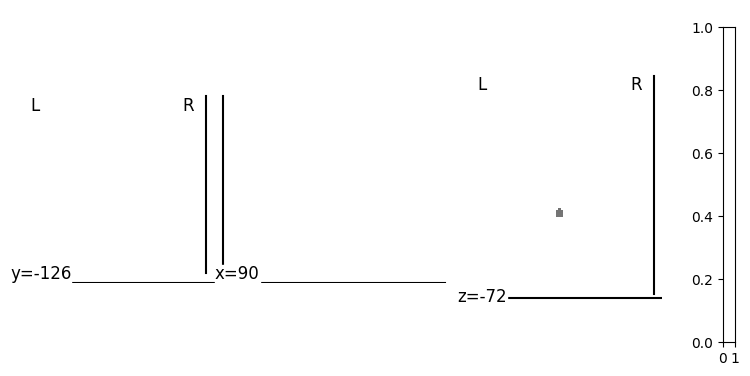

In [ ]:
# Para graficar en 4D, solo acepta .nii, no .BRIK::
from nilearn import image
from nilearn import plotting
from nilearn.image import load_img

otra_de_prueba = r'/content/drive/MyDrive/100307/reho.nii.gz'
first_rsn = image.index_img(otra_de_prueba, 0) # nos da el primer volumen temporal de la serie
plotting.plot_stat_map(first_rsn)

# si queremos graficar ciertos volúmenes en 4D:

# selected_volumes = image.index_img(fmri_file_path, slice(3, 5))
# for img in image.iter_img(selected_volumes):
#     plotting.plot_stat_map(img)

# Features:

Ejecutamos los códigos que nos permitan extraer de nuestra data features útiles.

Partimos con ReHo:

## ReHo:

Ya vimos este, veía la homogeneidad en distintas regiones del cerebro y su similaridad de 0 a 1. Se ve a lo largo del tiempo si un voxel es similar a su vecino, es decir, qué voxels son parte de la zona que está activa o de las zonas que no están activas, permitiendo un mapeo.

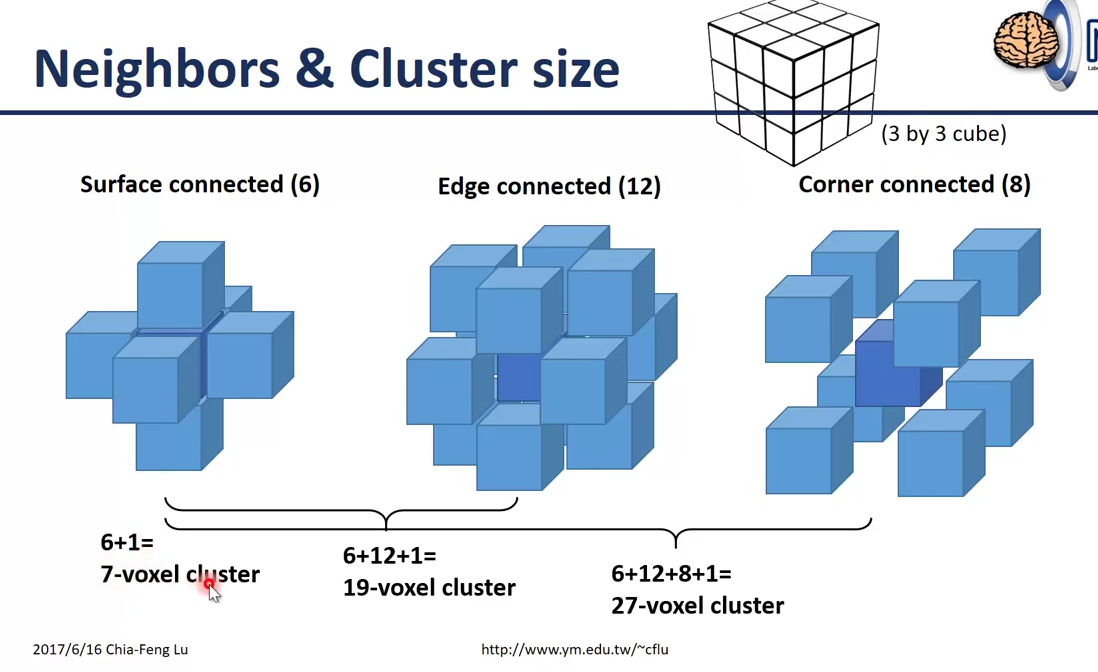

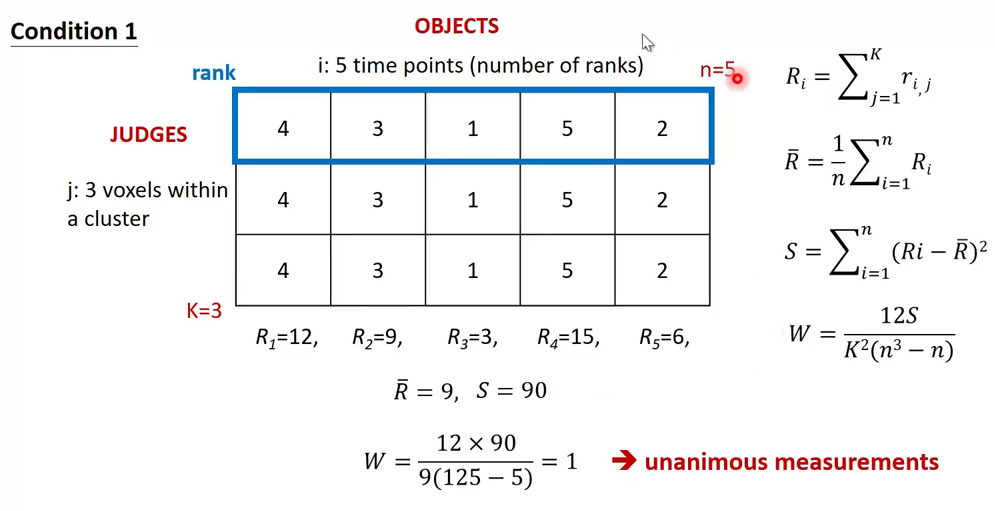

In [ ]:
# --------------------------- ReHo -----------------------------

import numpy as np
import nibabel as nib
from scipy.stats import rankdata
from nilearn import image

def calculate_reho(fmri_file):
    # Cargar el archivo fMRI
    fmri_img = nib.load(fmri_file)
    fmri_data = fmri_img.get_fdata()

    reho_data = np.zeros_like(fmri_data)
    for i in range(fmri_data.shape[0]):
        for j in range(fmri_data.shape[1]):
            for k in range(fmri_data.shape[2]):
                # Extract the 3x3x3 neighborhood around the current voxel
                neighborhood_data = fmri_data[i-1:i+2, j-1:j+2, k-1:k+2, :]

                # Calculate Kendall's coefficient of concordance (KCC)
                ri = np.sum(neighborhood_data)
                S = np.var(ri)
                W = 12 * S / (27 * 27 * (fmri_data.shape[-1]**3 - fmri_data.shape[-1]))

                # Assign the ReHo value to the current voxel
                reho_data[i, j, k] = W

    reho_img = nib.Nifti1Image(reho_data, fmri_img.affine, fmri_img.header)
    return reho_img


reho_result = calculate_reho(fmri_file_path)

# Guardar el resultado
nib.save(reho_result, "/content/drive/MyDrive/100307/reho_2.nii.gz")


## ALFF y fALFF

También ya los vimos un poco. Estos medían la amplitud de la señal y la segunda de las bajas señales. Usualmente para el primero se filtran datos en la frecuencia de 0.01 - 0.08 Hz, pues fuera de esto se considera problemático. Luego con estos datos ya filtrados se hace una transformada de Fourier para extraer un espectro de señales que se normaliza. fALFF es menos sensible al ruido y es posee más especificidad, en este se saca el radio del espectro respecto a la frecuencia completa.

Ojo: Después de hacer que la data pase por el bandpass se vuelve LFF (al parecer con regressor_censor no funciona bien ALFF). The related parameter RSFA was introduced and discussed by Kannurpatti & Biswal (2008). No se puede obtener fALFF una vez echo 3dTproject porque ya no está el espectro completo de frecuencias.

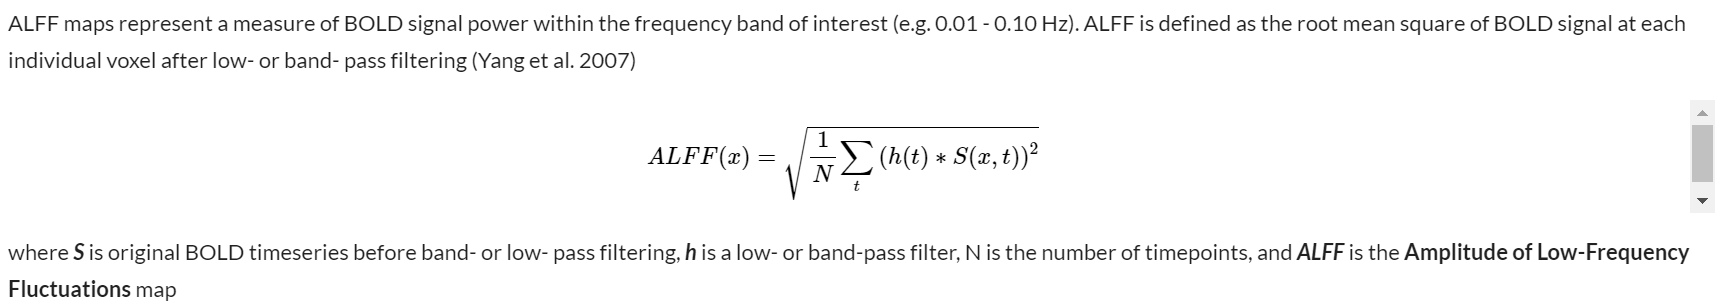

Extracción de la Serie Temporal:

Para cada voxel en la imagen fMRI, se extrae una serie temporal que representa la variación de la señal BOLD en ese voxel a lo largo del tiempo.
Transformada de Fourier:

Se aplica la transformada de Fourier a la serie temporal de cada voxel para convertirla del dominio temporal al dominio de la frecuencia. Esto descompone la señal en sus componentes de frecuencia.


El ALFF (Amplitude of Low-Frequency Fluctuations) es una medida utilizada en estudios de resonancia magnética funcional (fMRI) para cuantificar la amplitud de las fluctuaciones de baja frecuencia en la señal BOLD (Blood-Oxygen-Level-Dependent). Estas fluctuaciones suelen estar en el rango de 0.01 a 0.1 Hz y se cree que reflejan la actividad neuronal espontánea en reposo.

### Fórmula y Proceso de Cálculo de ALFF:

1. **Preprocesamiento**: Se preprocesan los datos de fMRI para corregir movimientos, alinearlos, normalizarlos y suavizarlos.

2. **Transformada de Fourier**: Se aplica la transformada de Fourier a cada voxel de la imagen preprocesada para convertir los datos de dominio temporal al dominio de la frecuencia.
   \[
   X(f) = \int_{-\infty}^{\infty} x(t) e^{-2\pi ift} dt
   \]
   donde \( x(t) \) es la señal de tiempo y \( X(f) \) es la señal transformada en el dominio de la frecuencia.

3. **Espectro de Potencia**: Se calcula el espectro de potencia de la señal transformada.
   \[
   P(f) = |X(f)|^2
   \]
   donde \( P(f) \) es el espectro de potencia en la frecuencia \( f \).

4. **Selección del Rango de Frecuencia**: Se selecciona el rango de frecuencia de interés, típicamente de 0.01 a 0.1 Hz.

5. **Amplitud de las Fluctuaciones de Baja Frecuencia (ALFF)**:
   \[
   ALFF = \sqrt{\sum_{f \in [0.01, 0.1]} P(f)}
   \]
   donde la suma se realiza sobre el rango de frecuencias de interés. Es decir, se calcula la raíz cuadrada de la suma del espectro de potencia dentro del rango de baja frecuencia.

### Interpretación:

- **ALFF**: Representa la magnitud promedio de las fluctuaciones de baja frecuencia en la señal BOLD. Valores más altos de ALFF indican una mayor amplitud de estas fluctuaciones, lo que puede estar relacionado con un mayor nivel de actividad neuronal espontánea en esa región cerebral.

### Resumen del Proceso:

1. **Preprocesamiento de datos fMRI**: Corrección de movimientos, alineación, normalización y suavizado.
2. **Transformada de Fourier**: Conversión de la señal temporal al dominio de la frecuencia.
3. **Cálculo del Espectro de Potencia**: Obtención del espectro de potencia de la señal transformada.
4. **Selección del Rango de Frecuencia**: Selección del rango de baja frecuencia (0.01 a 0.1 Hz).
5. **Cálculo de ALFF**: Suma del espectro de potencia en el rango seleccionado y cálculo de la raíz cuadrada.

Este proceso permite obtener una medida cuantitativa de la actividad cerebral espontánea en reposo, que puede ser utilizada para comparar diferentes condiciones experimentales o grupos de sujetos en estudios de neuroimagen.

In [ ]:
# -------------------------  ALFF ---------------------------

import nibabel as nib
import numpy as np
import nilearn
from nilearn.input_data import NiftiMasker
from scipy.signal import butter, sosfilt

# Function to calculate ALFF
def calculate_alff(func_file, tr):
    # Load the functional data
    func_img = nib.load(func_file)

    # Convert to NIfTI image
    nifti_img = nib.Nifti1Image(func_img.get_fdata(), func_img.affine, header=func_img.header)

    # Extract the time series
    masker = NiftiMasker(mask_strategy='epi', standardize=True)
    time_series = masker.fit_transform(nifti_img)

    # Design a butterworth filter
    lowcut = 0.01
    highcut = 0.08
    nyquist = 0.5 / tr
    low = lowcut / nyquist
    high = highcut / nyquist

    # Filter the time series data
    sos = butter(1, [low, high], btype='band', output='sos')
    filtered_data = sosfilt(sos, time_series, axis=0)

    # Calculate ALFF
    alff = np.sum(np.square(filtered_data), axis=0)  # Sum along the axis of time (samples)

    # Create a Nifti image from the ALFF values
    alff_img = masker.inverse_transform(alff.reshape(1, -1))

    return alff_img

# Replace with your TR (time repetition) value
tr = 0.72

# Calculate ALFF
alff_result = calculate_alff(fmri_file_path, tr)

# Save the result
alff_result.to_filename('/content/drive/MyDrive/100307/alff_result.nii.gz')


In [ ]:
#!/usr/bin/env python


# ---------------------------------- fALFF -------------------------------------


# de https://github.com/edickie/ciftify/blob/master/ciftify/bin/ciftify_falff.py

"""
Options:
  --min-low-freq 0.01  Min low frequency range value Hz [default: 0.01]
  --max-low-freq 0.08  Max low frequency range value Hz [default: 0.08]
  --min-total-freq 0.00  Min total frequency range value Hz [default: 0.00]
  --max-total-freq 0.25  Max total frequency range value Hz [default: 0.25]
"""

import os
import numpy as np
import nibabel as nib
from scipy.fftpack import fft
from docopt import docopt
from ciftify.utils import run, TempDir
from ciftify.meants import NibInput
import ciftify.config
import logging
import sys

config_path = os.path.join(os.path.dirname(ciftify.config.find_ciftify_global()), 'bin', "logging.conf")
logging.config.fileConfig(config_path, disable_existing_loggers=False)

funcfile = load_img(fmri_file_path)
tr = 0.72
outputname = '<falff_output.nii.gz>'
min_low_freq = 0.01
max_low_freq = 0.08
nyquist = 0.5 / tr
min_total_freq = min_low_freq / nyquist
max_total_freq = max_low_freq / nyquist
# maskfile = arguments['--mask-file'] # tampoco es necesaria la máscara, pero nos ahorra tiempo, es algo con forma de nuestro cerebro
calc_alff = True # True or False, nos dice cómo va a ser el cálculo


def calc_nifti(inputfile, maskfile, min_low_freq, max_low_freq, min_total_freq, max_total_freq, calc_alff):
    '''
    calculates falff from nifti input and retruns nifti output

    Takes input files to give to falff function and returns output file
    '''
    # Load in functional data
    func_img = nib.load(inputfile)
    func_data = func_img.get_data()

    # If given input of mask, load in mask file
    # OR if not given input of mask, create mask using std
    if maskfile:
        #1. Given input of mask file
        mask = (nib.load(maskfile)).get_data()
    else:
        #2. Manually create mask
        mask = np.std(func_data, axis=3)

    # Find indices where mask does not = 0
    indx,indy,indz = np.where(mask != 0)

    # Define affine array
    affine = func_img.affine

    # Define x,y,z,t coordinates
    x,y,z,t = func_data.shape

    # Create empty array to save values
    falff_vol = np.zeros((x,y,z))

    # Loop through x,y,z indices, send to calculate_falff function
    for x,y,z in zip(indx,indy,indz):
        falff_vol[x,y,z] = calculate_falff(func_data[x,y,z,:], min_low_freq, max_low_freq, min_total_freq, max_total_freq, calc_alff)

    # Save falff values to fake nifti output temp file
    output_3D = nib.Nifti1Image(falff_vol, affine)

    return output_3D

# CALCULATES FALFF
def calculate_falff(timeseries, min_low_freq, max_low_freq, min_total_freq, max_total_freq, calc_alff):
    ''' this will calculate falff from a timeseries'''

    n = len(timeseries)
    time = (np.arange(n))*2

    # Takes fast Fourier transform of timeseries
    fft_timeseries = fft(timeseries)
    # Calculates frequency scale
    freq_scale = np.fft.fftfreq(n, 1/1)

    # Calculates power of fft
    mag = (abs(fft_timeseries))**0.5

    # Finds low frequency range (0.01-0.08) and total frequency range (0.0-0.25)
    low_ind = np.where((float(min_low_freq) <= freq_scale) & (freq_scale <= float(max_low_freq)))
    total_ind = np.where((float(min_total_freq) <= freq_scale) & (freq_scale <= float(max_total_freq)))

    # Indexes power to low frequency index, total frequency range
    low_power = mag[low_ind]
    total_power = mag[total_ind]
    # Calculates sum of lower power and total power
    low_pow_sum = np.sum(low_power)
    total_pow_sum = np.sum(total_power)

    # Calculates alff as the sum of amplitudes within the low frequency range
    if calc_alff:
        calc = low_pow_sum
    # Calculates falff as the sum of power in low frequnecy range divided by sum of power in the total frequency range
    else:
        calc = np.divide(low_pow_sum, total_pow_sum)

    return calc

falff_result = calc_nifti(fmri_file_path, False, min_low_freq, max_low_freq, min_total_freq, max_total_freq, False)

# Save the result
falff_result.to_filename('/content/drive/MyDrive/100307/falff_result.nii.gz')

<ipython-input-38-a8f207839aa2>:47: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  func_data = func_img.get_data()


## Conectividad funcional:

Este se extrae directamente de las series de tiempo, así que suele ser el feature que se extrae cuando se utilizan estas, añadiéndolas como una matriz de tiempoxn_voxel, y se suele hacer por parcelaciones para que pese menos y solo tenga la data importante. En este código usamos una parcelación 'cort-maxprob-thr25-2mm' sacada de internet.


Functional connectivity is quantified using measures of statistical dependence between neural time series. This means that, in principle, functional connectivity can be quantified using any generic method for estimating statistical dependencies in time series data. Functional connectivity refers to the statistical relationship between specific physiological signals in time and are generally assessed. The rationale behind this technique is based on the construct that synchronization between two brain structures (either at rest or during the performance of a specific task) reflects communication between these regions. It is important to realize that, although functional connectivity is somehow constraint by anatomical connectivity, the two are not necessarily correlated with each other. That is, two regions are considered to show functional connectivity if there is a statistical relationship between the measures of activity recorded for them.

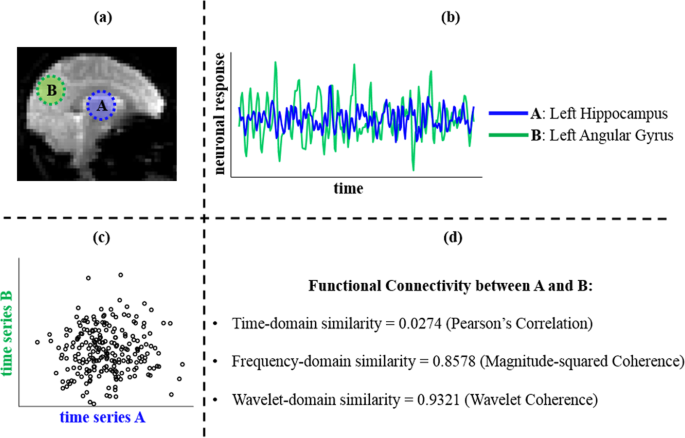

Conventional quantification of FC by Pearson's correlation captures linear, time-domain dependencies among blood-oxygen-level-dependent (BOLD) signals.

Within-network functional connectivity for each RSN was computed by averaging the Pearson’s correlation between the time series of all the voxels of the ROIs assigned to each particular network. For between-network functional connectivity, we first calculated an average time series within each RSN (as described above) and then computed the Pearson’s correlation between the time series of each network and all the other networks.

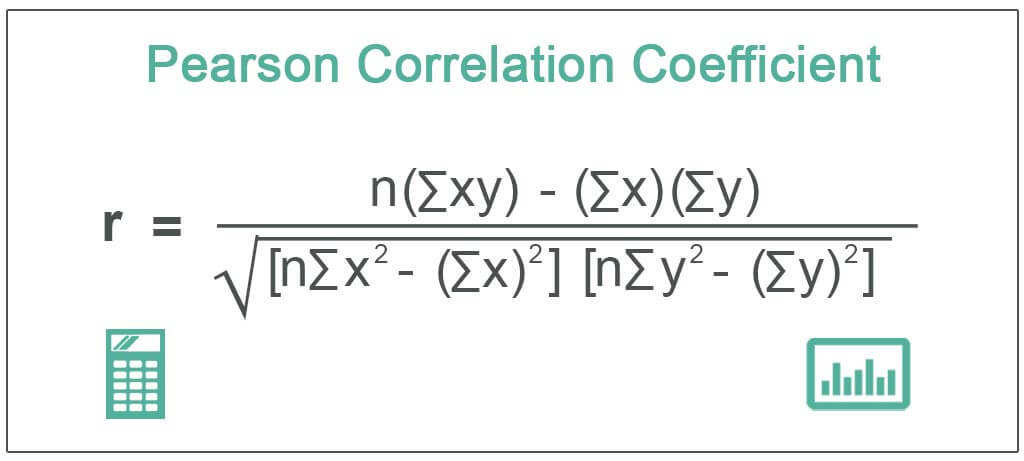

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <msub>
    <mrow class="MJX-TeXAtom-ORD">
      <mi>&#x03C1;<!-- ρ --></mi>
    </mrow>
    <mrow class="MJX-TeXAtom-ORD">
      <mi>c</mi>
      <mi>o</mi>
      <mi>r</mi>
      <mi>r</mi>
    </mrow>
  </msub>
  <mo stretchy="false">(</mo>
  <mi>x</mi>
  <mo>,</mo>
  <mi>y</mi>
  <mo stretchy="false">)</mo>
  <mo>=</mo>
  <mfrac>
    <mrow>
      <mi>c</mi>
      <mi>o</mi>
      <mi>v</mi>
      <mo stretchy="false">(</mo>
      <mi>x</mi>
      <mo>,</mo>
      <mi>y</mi>
      <mo stretchy="false">)</mo>
    </mrow>
    <msqrt>
      <mi>v</mi>
      <mi>a</mi>
      <mi>r</mi>
      <mo stretchy="false">(</mo>
      <mi>x</mi>
      <mo stretchy="false">)</mo>
      <mi>v</mi>
      <mi>a</mi>
      <mi>r</mi>
      <mo stretchy="false">(</mo>
      <mi>y</mi>
      <mo stretchy="false">)</mo>
    </msqrt>
  </mfrac>
  <mo>=</mo>
  <mfrac>
    <mrow>
      <mo stretchy="false">(</mo>
      <mi>x</mi>
      <mo>&#x2212;<!-- − --></mo>
      <mover>
        <mi>x</mi>
        <mo accent="false">&#x00AF;<!-- ¯ --></mo>
      </mover>
      <mo stretchy="false">)</mo>
      <msup>
        <mrow class="MJX-TeXAtom-ORD">
          <mo stretchy="false">(</mo>
          <mi>y</mi>
          <mo>&#x2212;<!-- − --></mo>
          <mover>
            <mi>y</mi>
            <mo accent="false">&#x00AF;<!-- ¯ --></mo>
          </mover>
          <mo stretchy="false">)</mo>
        </mrow>
        <mrow class="MJX-TeXAtom-ORD">
          <mi>T</mi>
        </mrow>
      </msup>
    </mrow>
    <mrow>
      <mo stretchy="false">(</mo>
      <msqrt>
        <mo stretchy="false">(</mo>
        <mi>x</mi>
        <mo>&#x2212;<!-- − --></mo>
        <mover>
          <mi>x</mi>
          <mo accent="false">&#x00AF;<!-- ¯ --></mo>
        </mover>
        <mo stretchy="false">)</mo>
        <msup>
          <mrow class="MJX-TeXAtom-ORD">
            <mo stretchy="false">(</mo>
            <mi>x</mi>
            <mo>&#x2212;<!-- − --></mo>
            <mover>
              <mi>x</mi>
              <mo accent="false">&#x00AF;<!-- ¯ --></mo>
            </mover>
            <mo stretchy="false">)</mo>
          </mrow>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>T</mi>
          </mrow>
        </msup>
      </msqrt>
      <mo stretchy="false">)</mo>
      <mo fence="false" stretchy="false">{</mo>
      <msqrt>
        <mo stretchy="false">(</mo>
        <mo stretchy="false">(</mo>
        <mi>y</mi>
        <mo>&#x2212;<!-- − --></mo>
        <mover>
          <mi>y</mi>
          <mo accent="false">&#x00AF;<!-- ¯ --></mo>
        </mover>
        <mo stretchy="false">)</mo>
        <msup>
          <mrow class="MJX-TeXAtom-ORD">
            <mo stretchy="false">(</mo>
            <mi>y</mi>
            <mo>&#x2212;<!-- − --></mo>
            <mover>
              <mi>y</mi>
              <mo accent="false">&#x00AF;<!-- ¯ --></mo>
            </mover>
            <mo stretchy="false">)</mo>
          </mrow>
          <mrow class="MJX-TeXAtom-ORD">
            <mi>T</mi>
          </mrow>
        </msup>
        <mo stretchy="false">)</mo>
      </msqrt>
      <mo fence="false" stretchy="false">}</mo>
    </mrow>
  </mfrac>
</math>

In [ ]:
# -------------------------  serie de tiempo en parcelaciones ---------------------------

import nilearn
import numpy as np
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import datasets, plotting
from nilearn.image import load_img

dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_filename = dataset.maps
labels = dataset.labels

def series_times_ROI(func):

    # masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True)
    masker = NiftiLabelsMasker(
    labels_img=atlas_filename,
    standardize="zscore_sample",
    standardize_confounds="zscore_sample",
    memory="nilearn_cache",
    verbose=5,
    )

    time_series = masker.fit_transform(func) # se agregan aquí también los cofounds como variable

    return time_series

# Load functional data and confounds
func_img = load_img(fmri_file_path)
# confounds = np.loadtxt(confounds_file) esto se puede introducir como variable para considerar el ruido por movimiento

# Get timeseries for a single subject
time_series = series_times_ROI(func_img)  # aquí extraemos la serie de tiempo !


[NiftiLabelsMasker.wrapped] loading data from Nifti1Image(
shape=(91, 109, 91),
affine=array([[   2.,    0.,    0.,  -90.],
       [   0.,    2.,    0., -126.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling labels
[Memory]2.6s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


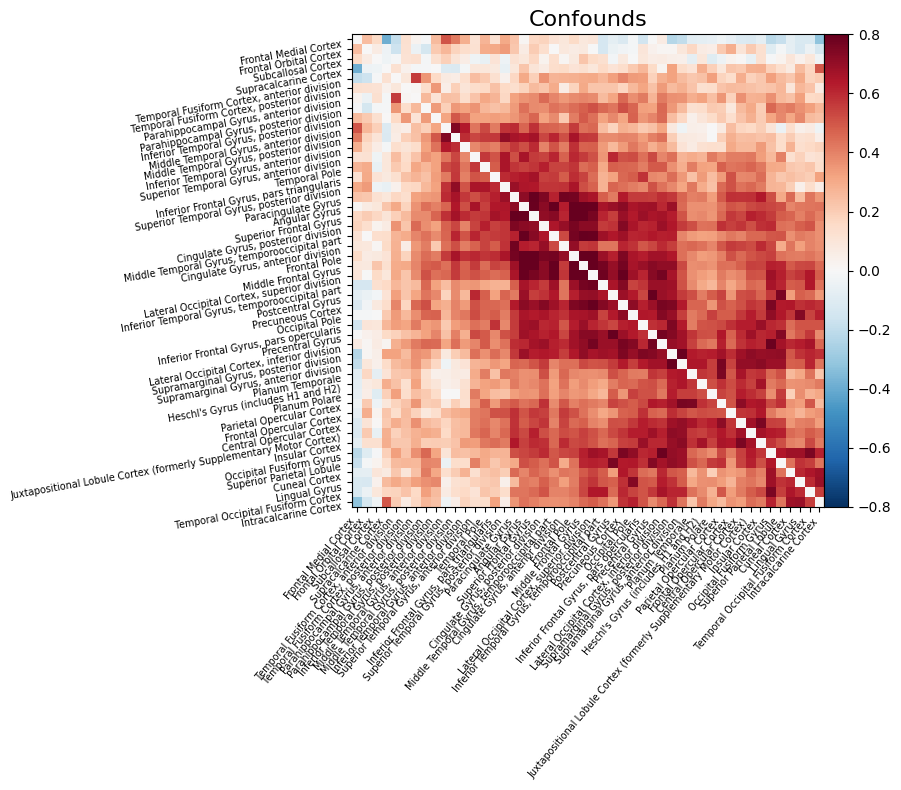

In [ ]:
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
import numpy as np

correlation_measure = ConnectivityMeasure(
    kind="correlation",
    standardize="zscore_sample",
)
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Plot the correlation matrix -> esta nos da qué tan parecidas son distintas zonas del cerebro con otras !

# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(
    correlation_matrix,
    figure=(10, 8),
    labels=labels[1:],
    vmax=0.8,
    vmin=-0.8,
    title="Confounds",
    reorder=True,
)


En las matrices de conectividad (esta de aquí arriba), las celdas de colores representan la alta o baja conección que existe entre las distintas áreas. Lo rojo representa que hay conectividad positiva, es decir que la zona se activa, azul significa que se desactiva uno respecto al otro a lo largo del tiempo, y blanco significa que no hay cambio respecto al otro, es decir que cambian de forma similar en el tiempo.

https://www.researchgate.net/figure/Example-of-a-functional-connectivity-matrix-network-before-and-after-thresholding-with_fig3_323192505

Los confounds son variables externas que afectan la data, en este caso probablemente ruido, y que hay que tener en cuenta para ver cómo afecta a la conectividad.

https://peerherholz.github.io/workshop_weizmann/advanced/functional_connectivity.html

## EC:

Eigenvector centrality, esta le otorga un valor a cada voxel del cerebro; si este es alto, significa que está muy conectado a otros nodos importantes.

Si tenemos una matriz de similaridad A de $nxn$ como la anterior, con entradas $a_{i,j}$, definimos EC como la suma de la centralidad de los vecinos. Esta se define en "power iterations" que parten en un vector $v_{0}$ y siguen como:

$v_{i+1} =R∗v_{i}$

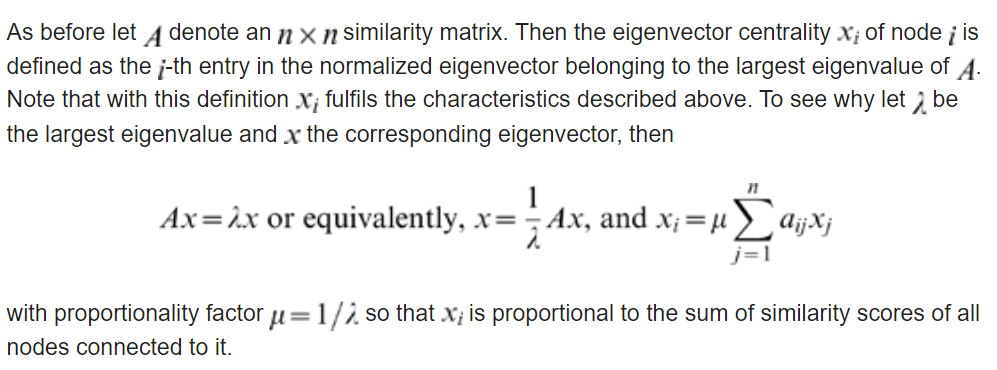


Eigenvector centrality is related to principal components analysis (PCA) in that both methods are based on eigenvector decompositions of similarity matrices. However, PCA differs from eigenvector centrality in that it only allows linear correlations as a similarity metric. But linear correlations may be negative so that the first principal component is not uniquely defined because of possible multiplicities of eigenvalues.

Entonces, se van haciendo iteraciones con la matriz de conectividad entre los nodos como en el siguiente ejemplo:

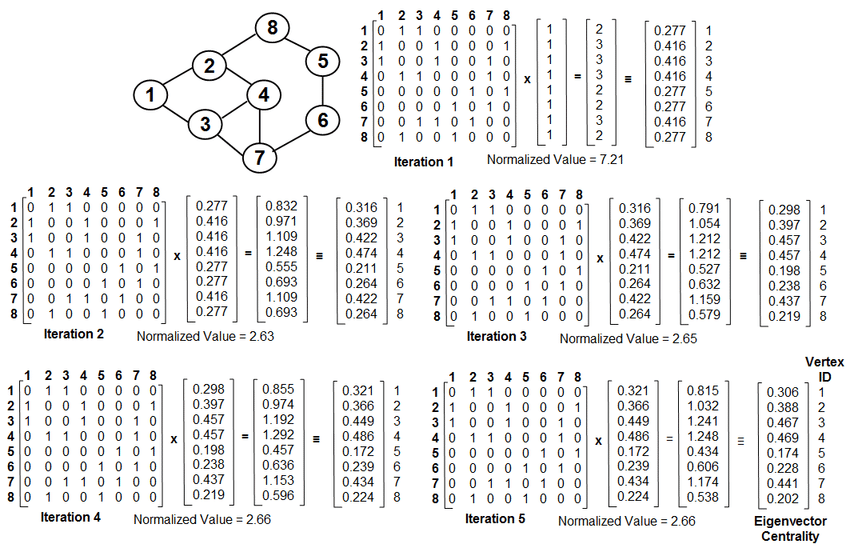

Por lo que entiendo, esta matriz de similaridad se hace en base a una matriz de los valores de FC o de pearson o alguna otra métrica de conectividad# .

In [ ]:
# --------------------------- Eigenvector centrality ----------------------

import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

def fastECM(inputfile = '',
            maskfile  = False, # cambiar a '' si se tiene
            atlasfile = False, # cambiar a '' si se tiene
            verbose   = True,
            dynamics  = 1,
            rankmap   = 0,
            normmap   = 0,
            degmap    = 0,
            maxiter   = 42,
            wholemat  = 0):


    #   URL:    https://github.com/amwink/bias/blob/master/python/fastECM/fastECM.py

    err=0

    # load the input file
    img            = nib.load(fmri_file_path)        # open nifti file using nibabel
    m              = np.asarray(img.dataobj)    # quickest way to get to the data
    m[np.isnan(m)] = 0                          # set NaNs to 0

    # get the data to re-format to the right size
    msz = m.shape                               # get the (assumed 4) dimensions of the data
    tln = msz[3]                                # 4th dimension (3): time series length
    msz = msz[:3]                               # first 3 dimensions: size of volume
    msk = (m.min(3)>0)                          # mask: minimum over time > 0 -> 1, else 0



    # # if a maskfile was supplied, use this as a mask as well    ------>      no lo tenemos

    # if maskfile:
    #     img_mask=nib.load(maskfile)             # open nifti file
    #     mmsk=np.asarray(img_mask.dataobj)       # get voxel data
    #     msk=msk*(mmsk>0).astype(float)          # mask within available data

    # # if an atlasfile was supplied, sample with (atlas & mask) and correlate labels
    # if atlasfile:
    #     img_atl=nib.load(atlasfile)             # open nifti file
    #     matl=np.asarray(img_atl.dataobj)        # get voxel data
    #     msk=msk*(matl>0).astype(float)          # mask within available atlas data
    #     matl=matl*(msk>0).astype(float)         # only sample atlas within mask
    # else:
    #     matl=0
    matl=0

    # apply the final mask and count the number of voxels
    msk = msk.reshape(np.prod(msz))             # reshape msk as a 1D vector # este debe ser el vector 0 por el cual multiplicar
    m = m.reshape(np.prod(msz),tln).transpose() # reshape m as a sequence of vectors
    m = m[:,np.nonzero(msk)].squeeze()          # remove singleton dimensions
    msk = msk.reshape(msz)
    npt = m.shape[1]                            # count the number of voxels in the mask

    # # when an atlas is used, signals are grouped within atlas regions
    # if atlasfile:
    #     msk = msk.reshape(np.prod(msz))         # reshape msk as a 1D vector
    #     matl=matl.reshape(np.prod(msz))         # same 1D shape as mask above
    #     matl=matl[np.nonzero(msk)].squeeze()    # sample matl in mask (same size as m)
    #     regs=np.unique(matl[np.where(matl>0)])  # find the used region values
    #     rgts=np.zeros((tln,len(regs)))          # regional time series
    #     for t in range(len(regs)):
    #         #print regs[t]
    #         rgts[:,t]=np.mean(m[:,np.where(matl==regs[t])], axis=2).squeeze()
    #     m=rgts                                  # now m contains regional mean time series
    #     np.savetxt(os.path.abspath(inputfile).replace(".nii.gz","_fastECM.txt"),m,fmt="%d")
    #     npt=len(regs)
    #     msk  = msk.reshape(msz)

    # Initialize eigenvector estimate
    vprev = 0                                   # initialize previous ECM estimate
    vcurr = np.ones((npt,1))/np.sqrt(npt)       # initialize estimate with L2-norm == 1

    i = 0                                       # reset iteration counter
    dnorm = 1                                   # initial value for difference L2-norm
    cnorm = 0                                   # initial value to estimate L2-norm

    # Efficient power iteration
    while (i < maxiter) & (dnorm > cnorm):
        vprev   = vcurr                         # start with previous estimate
        prevsum = vprev.sum()                   # sum of estimate
        vcurr_1 = m.dot(vprev)                  # part one of M*v
        vcurr_2 = m.T.dot(vcurr_1)              # part two of M*v
        vcurr_3 = vcurr_2 + prevsum             # adding sum -- same effect as [M+1]*v
        vcurr   = vcurr_3/np.linalg.norm(vcurr_3,2)    # normalize L2-norm

        i += 1                                         # next iteration
        dnorm = np.linalg.norm(vcurr-vprev, 2)         # L2 norm of difference with previous result
        cnorm = np.linalg.norm(vcurr,2)*np.spacing(1)  # L2 norm of current result

    # write the ECM
    write_map(inputfile,img,vcurr,msk,matl)

    # return 0 if no error
    return err

def write_map (inputfile='',
               img=0,
               vcurr=0,
               msk=0,
               atl=0,
               mapfile='',
               descrip=''):

    if np.prod(atl):
        vcurr_2=np.zeros(atl.shape)             # allocate in-brain voxels
        regs=np.unique(atl)                     # find the used region values
        for t in range(0,len(regs)):
            all_t=np.where(atl==t)
            vcurr_2[all_t] = vcurr[t]#/len(all_t)
        vcurr=vcurr_2                           # now m contains regional mean time series

    outputfile=os.path.abspath(inputfile).replace(".nii","_fastECM.nii")
    msz=msk.shape                                # size of the volume
    msk=np.reshape(msk,np.prod(msz))             # 1D vector of the same size
    vout=msk.astype('float32')                   # output: zero outside mask
    vout[np.nonzero(msk)]=vcurr                  # put vcurr inside mask
    vout=np.reshape(vout,msz).astype('float32')  # resize to volume

    img_out=nib.Nifti1Image(vout,img.get_affine())
    img_out.to_filename(outputfile)

fastECM(fmri_file_path) # agregar otros archivos de mask y atlas (MNI) si se tienen

TypeError: stat: path should be string, bytes, os.PathLike or integer, not AFNIImage

In [ ]:
# ---------------- otro código que lo hace, llamémoslo b. --------------------------------
# https://dartbrains.org/content/Connectivity.html


%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import zscore, fdr, one_sample_permutation
from nltools.file_reader import onsets_to_dm
from nltools.plotting import component_viewer
from scipy.stats import binom, ttest_1samp
from sklearn.metrics import pairwise_distances
from copy import deepcopy
import networkx as nx
from nilearn.plotting import plot_stat_map, view_img_on_surf
from bids import BIDSLayout, BIDSValidator
import nibabel as nib

base_dir = '..'
data_dir = os.path.join(base_dir, 'data', 'localizer')
layout = BIDSLayout(data_dir, derivatives=True)

mask = Brain_Data('../masks/k50_2mm.nii.gz')

mask = Brain_Data('https://neurovault.org/media/images/8423/k50_2mm.nii.gz')

mask.plot()

In [ ]:
# Cada ROI tiene su propio valor para comparar la conectividad. Seguimos con b.

vmpfc = smoothed.extract_roi(mask=mask_x[32])

tr = layout.get_tr()
fwhm = 6  #     ---------------->     podemos modificar estos valores
n_tr = len(data)

#def make_motion_covariates(mc, tr): # ya hicimos esto la vdd
#    z_mc = zscore(mc)
#    all_mc = pd.concat([z_mc, z_mc**2, z_mc.diff(), z_mc.diff()**2], axis=1)
#    all_mc.fillna(value=0, inplace=True)
#    return Design_Matrix(all_mc, sampling_freq=1/tr)


vmpfc = zscore(pd.DataFrame(vmpfc, columns=['vmpfc']))

csf_mask = Brain_Data(os.path.join(base_dir, 'masks', 'csf.nii.gz'))
csf_mask = csf_mask.threshold(upper=0.7, binarize=True)
csf = zscore(pd.DataFrame(smoothed.extract_roi(mask=csf_mask).T, columns=['csf']))

# spikes = smoothed.find_spikes(global_spike_cutoff=3, diff_spike_cutoff=3)
# covariates = pd.read_csv(layout.get(subject=sub, scope='derivatives', extension='.tsv')[0].path, sep='\t')
# mc = covariates[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']]
# mc_cov = make_motion_covariates(mc, tr)
# dm = Design_Matrix(pd.concat([vmpfc, csf, mc_cov, spikes.drop(labels='TR', axis=1)], axis=1), sampling_freq=1/tr)
# dm = dm.add_poly(order=2, include_lower=True)

def load_bids_events(layout, subject):
    '''Create a design_matrix instance from BIDS event file'''

    tr = layout.get_tr()
    n_tr = nib.load(layout.get(subject=subject, scope='raw', suffix='bold')[0].path).shape[-1]

    onsets = pd.read_csv(layout.get(subject=subject, suffix='events')[0].path, sep='\t')
    onsets.columns = ['Onset', 'Duration', 'Stim']
    return onsets_to_dm(onsets, sampling_freq=1/tr, run_length=n_tr)

img = nib.load(fmri_file)

dm = load_bids_events(layout, 'S01')
motor_variables = ['video_left_hand','audio_left_hand', 'video_right_hand', 'audio_right_hand']
ppi_dm = dm.drop(motor_variables, axis=1)
ppi_dm['motor'] = pd.Series(dm.loc[:, motor_variables].sum(axis=1))
ppi_dm_conv = ppi_dm.convolve()
ppi_dm_conv['vmpfc'] = vmpfc
ppi_dm_conv['vmpfc_motor'] = ppi_dm_conv['vmpfc']*ppi_dm_conv['motor_c0']
dm = Design_Matrix(pd.concat([ppi_dm_conv, csf, mc_cov, spikes.drop(labels='TR', axis=1)], axis=1), sampling_freq=1/tr)
dm = dm.add_poly(order=2, include_lower=True)

dm.heatmap()



## DC

DC is a theory-based graph method to elucidate the connection degree between each node and other nodes in the network. To obtain each participant’s graph, Pearson correlation coefficients were computed between the time series of all pairs of brain voxels. As a result, we obtained an n × n matrix of Pearson correlation coefficients between any pair of voxels to construct the whole-brain FC matrix for each participant. Then, individual correlation matrices were transformed into a Z-score matrix using Fisher’s r-to-z transformation to improve normality. The weighted DC strength of a voxel as the sum of the connections (Z-values) between a given brain voxel and all other voxels was then computed. Furthermore, standardized weighted DC maps were acquired by subtracting the mean value, and then dividing by the standard deviation within the whole gray matter mask. Finally, the resulting DC maps were spatially smoothed with a 6-mm full width at half maximum (FWHM) Gaussian kernel.

For an undirected graph with g nodes, the degree centrality of node i is the total number of direct connections between i and other g-1 nodes, which is represented by a matrix as follows:

$DC_{i} = ∑ x_{ij}$

con x el valor de un nodo (creo que es el FC) y DC_i el DC de cada nodo i.

the following Fisher transformation formula was used to convert the correlation coefficient into a Z score, thus further improving the normality:

$Z_{i} = (DC_{i} - mean_{all})/ std_{all}$


where Zi is the Z score of the ith voxel.

https://www.frontiersin.org/articles/10.3389/fnhum.2019.00164/full


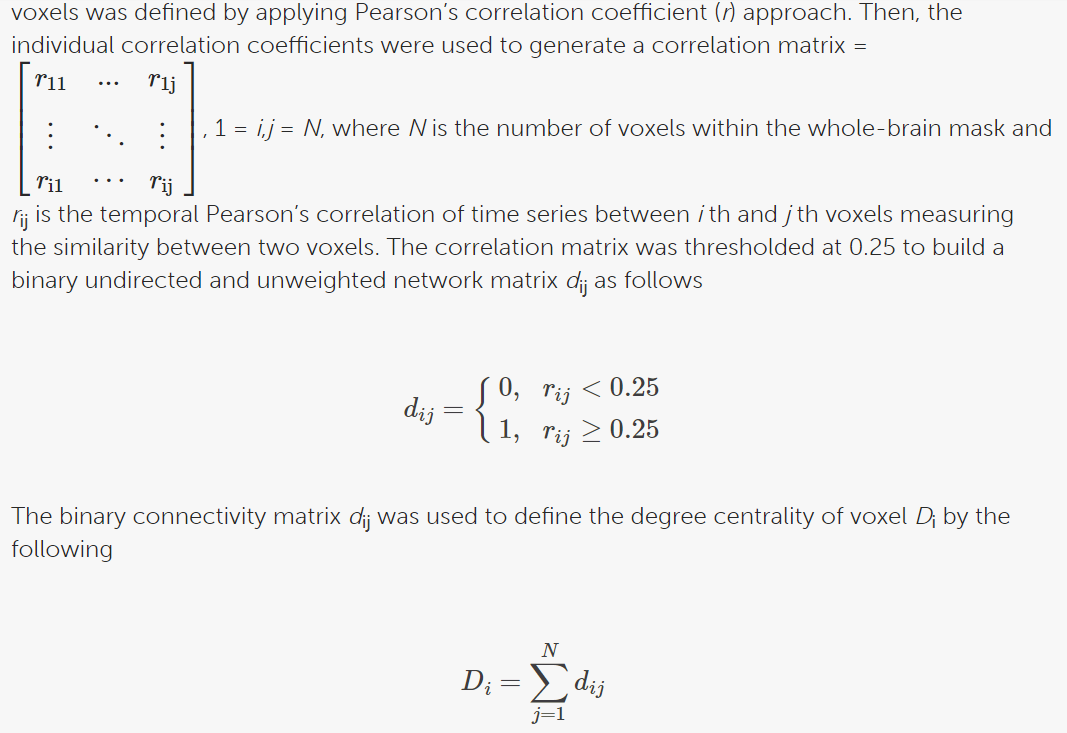

In [ ]:
# ---------------- Degree centrality a partir de lo hecho en b. ---------------------------

import matplotlib.pyplot as plt
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from bids import BIDSLayout, BIDSValidator
import os

# definimos cosas útiles:
base_dir = r'/content/drive/MyDrive/100307/errts.100307.tproject+tlrc.BRIK'
data_dir = os.path.join(base_dir, 'data', 'localizer')
layout = BIDSLayout(data_dir, derivatives=True)
data = Brain_Data(layout.get( task='localizer', scope='derivatives', suffix='bold', extension='nii.gz', return_type='file')[0])
smoothed = data.smooth(fwhm=fwhm)
stats = smoothed.regress()
smoothed_denoised = stats['residual']

mask = Brain_Data('https://neurovault.org/media/images/8423/k50_2mm.nii.gz') # parcelación como input

# Extract degree centrality
adjacency_matrix = smoothed_denoised.adjacency_matrix()
degree_centrality = Adjacency(adjacency_matrix).degree()

plt.figure(figsize=(15,5))
plt.plot(degree_centrality, marker='o')
plt.ylabel('Degree Centrality', fontsize=18)
plt.xlabel('Voxel Index', fontsize=18)
plt.show()


NameError: name 'load_img' is not defined

In [ ]:
roi_corr = 1 - pairwise_distances(rois, metric='correlation')

sns.heatmap(roi_corr, square=True, vmin=-1, vmax=1, cmap='RdBu_r')

In [ ]:
a = Adjacency(roi_corr, matrix_type='similarity', labels=[x for x in range(50)])
a_thresholded = a.threshold(upper=.6, binarize=True)

a_thresholded.plot()

In [ ]:
plt.figure(figsize=(20,15))
G = a_thresholded.to_graph()
pos = nx.kamada_kawai_layout(G)
node_and_degree = G.degree()
nx.draw_networkx_edges(G, pos, width=3, alpha=.2)
nx.draw_networkx_labels(G, pos, font_size=14, font_color='darkslategray')

nx.draw_networkx_nodes(G, pos, nodelist=list(dict(node_and_degree).keys()),
                       node_size=[x[1]*100 for x in node_and_degree],
                       node_color=list(dict(node_and_degree).values()),
                       cmap=plt.cm.Reds_r, linewidths=2, edgecolors='darkslategray', alpha=1)
Text(0.5, 0, 'Degree')

In [ ]:
degree = pd.Series(dict(G.degree()))
brain_degree = roi_to_brain(degree, mask_x)
brain_degree.plot()

In [ ]:
view_img_on_surf(brain_degree.to_nifti())

In [ ]:
import networkx as nx

# Step 1: Create a Graph
G = nx.Graph()

# Step 2: Add Nodes and Edges (replace this with your actual data)
# Example: Adding nodes and edges to the graph
G.add_nodes_from([1, 2, 3])  # Add nodes (replace [1, 2, 3] with your node IDs)
G.add_edges_from([(1, 2), (2, 3)])  # Add edges (replace (1, 2), (2, 3) with your edge connections)

# Step 3: Calculate Degree Centrality
degree_centrality = nx.degree_centrality(G)

# Print degree centrality for each node
for node, centrality in degree_centrality.items():
    print(f"Node {node}: Degree Centrality = {centrality}")


## HE

The Hurst exponent is used as a measure of long-term memory of time series. It relates to the autocorrelations of the time series, and the rate at which these decrease as the lag between pairs of values increases.

The Hurst exponent is referred to as the "index of dependence" or "index of long-range dependence". It quantifies the relative tendency of a time series either to regress strongly to the mean or to cluster in a direction.[5] A value H in the range 0.5–1 indicates a time series with long-term positive autocorrelation, meaning that the decay in autocorrelation is slower than exponential, following a power law; for the series it means that a high value tends to be followed by another high value and that future excursions to more high values do occur. A value in the range 0 – 0.5 indicates a time series with long-term switching between high and low values in adjacent pairs, meaning that a single high value will probably be followed by a low value and that the value after that will tend to be high, with this tendency to switch between high and low values lasting a long time into the future, also following a power law. A value of H=0.5 indicates short-memory, with (absolute) autocorrelations decaying exponentially quickly to zero.

.
.
.

+++++++++++++     Creo que este no nos es de interés     ++++++++++++++

## PCA

Ya lo vimos un poco, reduce la dimensionalidad de la data, es decir, hace que sea computacionalmente menos pesada.

Principal Components Analysis (PCA) is a multivariate procedure that attempts to explain the variance-covariance structure of a high dimensional random vector. In this procedure, a set of correlated variables are transformed int a set of uncorrelated variables, ordered by the amount of variance in the data that they explain. \\


In fMRI, we use PCA to find spatial maps or eigenimages in the data. This is usually computed using Singular Value Decomposition (SVD). This operation is defined as:

$ X = USV^{T}$, con $V^{T}V = I$ y $U^{T}U = I$, and S
 is a diagonal matrix whose elements are called singular values. \\


 In practice, V
 corresponds to the eigenimages or spatial components and U
 corresponds to the transformation matrix to convert the eigenimages into a timecourse.
 S reflects the amount of scaling for each component.

In [ ]:
csf_mask = Brain_Data(os.path.join(base_dir, 'masks', 'csf.nii.gz'))
csf = zscore(pd.DataFrame(smoothed.extract_roi(mask=csf_mask).T, columns=['csf']))

spikes = smoothed.find_spikes(global_spike_cutoff=3, diff_spike_cutoff=3)
covariates = pd.read_csv(layout.get(subject=sub, scope='derivatives', extension='.tsv')[0].path, sep='\t')
mc = covariates[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']]
mc_cov = make_motion_covariates(mc, tr)
dm = Design_Matrix(pd.concat([vmpfc, csf, mc_cov, spikes.drop(labels='TR', axis=1)], axis=1), sampling_freq=1/tr)
dm = dm.add_poly(order=2, include_lower=True)

smoothed.X = dm
stats = smoothed.regress()

smoothed_denoised=stats['residual']

n_components = 10

pca_stats_output = smoothed_denoised.decompose(algorithm='pca', axis='images', n_components=n_components)

component_viewer(pca_stats_output, tr=layout.get_tr())

## ICA

Independent Components Analysis (ICA) is a method to blindly separate a source signal into spatially independent components. This approach assumes that the data consts of
 spatially independent components, which are linearly mixed and spatially fixed. PCA assumes orthonormality constraint, while ICA only assumes independence.

 $X = UV$

  In resting state the time series of on-going
brain activity are unknown; hence both U and V must be estimated jointly.
Minimizing the squared norm of the residuals –an implicit Gaussian noise
assumption– leads to (U, V) spanning the subspace of an order-k PCA of
X.

Given that this equation only captures the
span of V, an additional criterion is needed to estimate the individual maps.
Maximizing a measure of independence between the maps leads to Independent Component Analysis (ICA), often used in signal processing to separate mixed signals. ICA on fMRI leads to well interpretable brain maps
that highlight known functional networks.

el Group Independent Component Analysis (Group-ICA) es una técnica avanzada utilizada en el análisis de datos de fMRI para identificar patrones de actividad cerebral que son comunes en un grupo de sujetos. ICA es una técnica de análisis ciego de fuentes (BSS) que descompone señales multivariadas en componentes independientes que son estadísticamente independientes entre sí. Cuando se aplica a datos de fMRI, ayuda a identificar redes funcionales del cerebro sin la necesidad de un modelo a priori.

¿Cómo Funciona el Group-ICA?
Preparación de los Datos:

Preprocesamiento: Los datos de fMRI de todos los sujetos se preprocesan individualmente. Esto incluye correcciones de movimiento, normalización espacial, suavizado y filtrado temporal.
Concatenación: Las series temporales preprocesadas de todos los sujetos se concatenan para formar una matriz grande que incluye los datos de todos los sujetos. Existen diferentes estrategias para esta concatenación (temporal o espacial).
Reducción de Dimensionalidad:

Análisis de Componentes Principales (PCA): Antes de aplicar ICA, los datos concatenados suelen ser reducidos en dimensionalidad utilizando PCA. Esto ayuda a reducir el ruido y a manejar la alta dimensionalidad de los datos fMRI. Generalmente, se realiza una reducción de dimensionalidad tanto a nivel individual (dentro de cada sujeto) como a nivel de grupo (en la matriz concatenada).
Aplicación de ICA:

ICA en el Conjunto de Datos Reducidos: ICA se aplica a la matriz de datos reducida para extraer componentes independientes. Cada componente independiente corresponde a una fuente de señal cerebral que es estadísticamente independiente de las demás.
Estimación de los Mapas Espaciales y las Series Temporales: ICA produce dos conjuntos de resultados: mapas espaciales y series temporales. Los mapas espaciales representan la distribución espacial de cada componente en el cerebro, mientras que las series temporales representan cómo varía la actividad de cada componente a lo largo del tiempo.
Reconstrucción de los Componentes Individuales:

Deconvolución a Nivel Individual: Una vez que se han identificado los componentes independientes a nivel de grupo, estos componentes se mapean de vuelta a los sujetos individuales. Esto permite analizar cómo se expresan las redes identificadas en cada sujeto.
Análisis e Interpretación:

Identificación de Redes Funcionales: Los componentes independientes obtenidos se interpretan como redes funcionales del cerebro, como la red por defecto, la red de control ejecutivo, etc.
Análisis de Conectividad y Comparaciones de Grupo: Los mapas espaciales y las series temporales se utilizan para realizar análisis adicionales, como la conectividad funcional y las comparaciones entre diferentes grupos de sujetos (por ejemplo, pacientes vs. controles).

Independent Component Analysis (ICA) es una técnica estadística utilizada para descomponer una señal multivariada en componentes independientes que son no gaussianos y estadísticamente independientes entre sí. ICA se usa en una variedad de aplicaciones, como el procesamiento de señales, el análisis de imágenes, y en particular, en el análisis de datos de fMRI para identificar redes funcionales del cerebro.

Fundamentos de ICA
Concepto Básico
ICA asume que una serie de observaciones (señales mezcladas) es una combinación lineal de varias fuentes independientes. El objetivo de ICA es descomponer estas señales mezcladas para recuperar las fuentes originales.

Matemáticamente, si tienes una matriz de observaciones
𝑋
X (donde cada fila es una observación y cada columna es una variable), ICA busca encontrar una matriz
𝑊
W tal que:

𝑆
=
𝑊
𝑋
S=WX

donde
𝑆
S son las fuentes independientes.

Suposiciones
Independencia Estadística: Las fuentes subyacentes son estadísticamente independientes entre sí.
No Gaussianidad: Las señales independientes tienen distribuciones no gaussianas.
Mezcla Lineal: Las señales observadas son combinaciones lineales de las fuentes independientes.
Pasos del ICA
Centro y Blanqueo de Datos:

Centro: Substraer la media de cada variable para que el conjunto de datos tenga media cero.
Blanqueo: Transformar los datos para que las variables sean no correlacionadas y tengan varianza unitaria.

## Clustering

Todo acto de agrupar data en regiones que asumimos tienen la misma activación, es clustering. Se puede usar nilearn.

From a data modeling perspective, clustering
can be seen as replacing the original data –resting-state time series– by its
average on a cluster. A criterion typically used is to seek a small distortion
between the original data and the cluster-level approximation. Formally,
for data X ∈ R –fMRI time series of length n acquired on p voxels– the
distortion on k clusters is usually written in terms of mean squared error
(MSE, the cluster distorsion):

$MSE = \sum^{k}_{j=1} \sum_{i∈C(j)} || X_{i} - c_{j} ||^{2} $

k-means clustering k-means clustering minimizes by alternating
computing the best cluster assignment and the best cluster centers.

The simplest approach to building a parcellation from a set of brain maps
is a hard parcellation “winner takes all” strategy, in which each parcel is
formed of voxels that have the largest weight across all maps (Figure 2.6b).
It forms non-overlapping parcels, which eases interpretation, but discards
potentially useful information in the fuzzy definition of regions.

SBC:

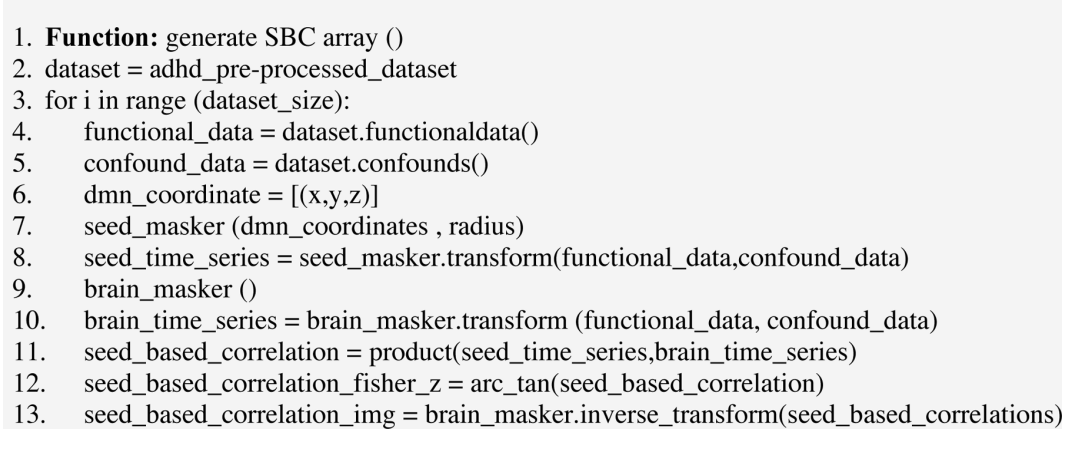

## Seed-based analysis:


 SCA involves extracting a time series from a priori selected seed region of the brain (voxel, cluster, or region of interest [ROI] in atlas). It then correlates them to all other voxels in the brain to detect regions of the brain that have coherent time courses, and which subsequently constitute a network, with this region.

 Seed-based functional connectivity is one of the most widely used methods in resting-state fMRI studies. It measures the linear temporal correlation between the seed regions and every other voxel in the whole brain. Assessing seed selection arbitrariness on studies’ results, the current meta-analysis revealed that the results of seed-based functional connectivity were exclusively affected by choice of seed. This was accomplished using image-based meta-analysis to identify seeds with relatively high reproducibility due to their high sensitivity. We then performed several image-based meta-analyses with 59 different DMN seeds from the retrieved articles. Among these meta-analytic maps, a very low degree of spatial overlap has been displayed. The overlap rate of most voxels in the whole brain was less than 10%, and the median Dice coefficient of all 59 seeds fluctuated wildly.

 Seed-based approaches find the connectivity of a seed to the rest of the brain. The seed can be a collection of points based on prior functional magnetic resonance imaging (fMRI) studies or be based on an atlas, in which case it is a seed with a larger region-of-interest (ROI).

 Seed-based connectivity metrics characterize the connectivity patterns with a pre-defined seed or ROI (Region of Interest). These metrics are often used when researchers are interested in one, or a few, individual regions and would like to analyze in detail the connectivity patterns between these areas and the rest of the brain. Perhaps the most common functional connectivity metric is seed-based connectivity maps (SBC), but there are also several variations aimed at studying potential connectivity paths (mSBC), estimating condition-specific connectivity measures (wSBC), or identifying task-related modulations in event-related designs (gPPI)

 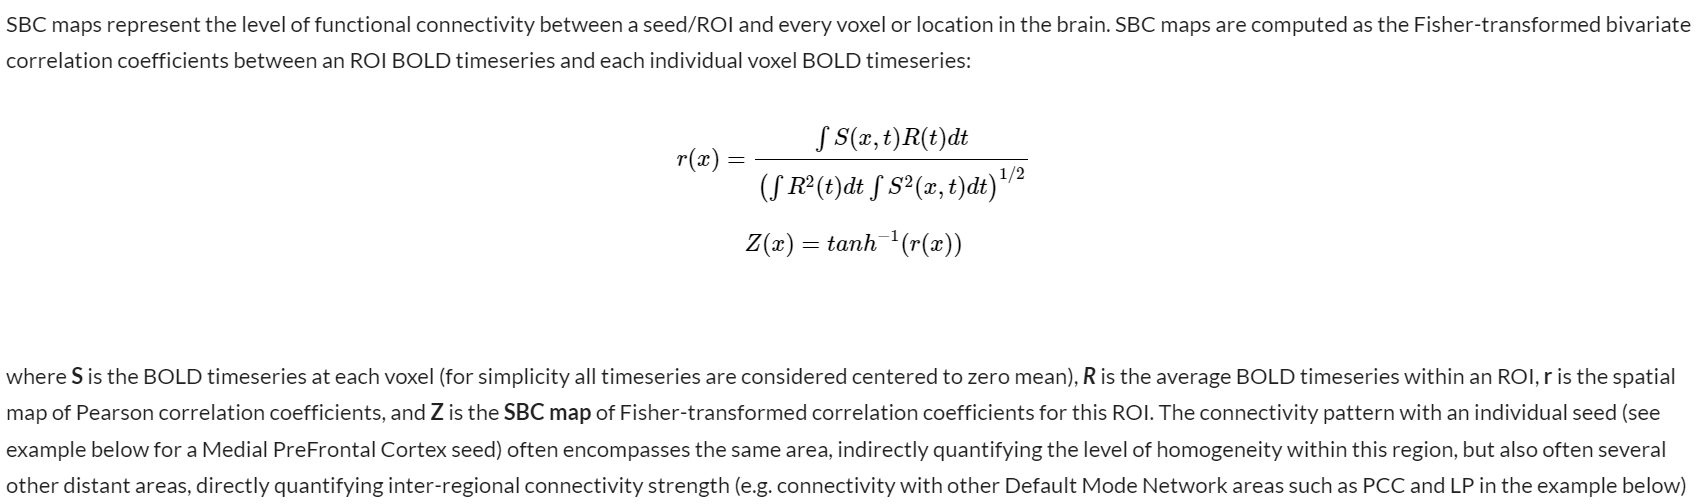

Selección de la Región de Interés (ROI):

Se elige una región específica del cerebro que servirá como la "semilla" para el análisis. Esta región puede ser seleccionada basándose en estudios previos, hipótesis anatómicas o funcionales, o resultados de análisis exploratorios.
Extracción de la Serie Temporal de la Seed:

Se extrae la serie temporal de la señal BOLD (Blood Oxygen Level Dependent) de todos los voxeles dentro de la región de interés. Generalmente, esta serie temporal se promedia para obtener una única serie temporal representativa de la región de la semilla.
Correlación con el Resto del Cerebro:

La serie temporal de la seed se correlaciona con las series temporales de todos los otros voxeles del cerebro para calcular la conectividad funcional. Esta correlación puede realizarse utilizando el coeficiente de correlación de Pearson u otras métricas de similitud.
Mapeo de Conectividad Funcional:

Los valores de correlación se transforman en un mapa de conectividad funcional, donde cada voxel en el cerebro tiene un valor que indica cuán similar es su actividad a la de la seed. Este mapa puede interpretarse como una medida de qué tan conectada está cada región del cerebro con la región de la seed.